In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import mat73
from scipy.linalg import dft
from scipy import linalg
from scipy.signal import butter, iirnotch, lfilter, freqz, filtfilt
from scipy.fft import fft, fftfreq
import warnings
%matplotlib inline

In [2]:
with open('ssvep/classInfo_4_5.m') as f:
    targets_str= f.read().split('\n')

targets=[]
for label in targets_str[:-1]:
    targets.append(list(map(int,label.split(' '))))

In [3]:
subject= 1
sub1_train1_data = 'ssvep/subject_1_fvep_led_training_1.mat'
sub1_train2_data = 'ssvep/subject_1_fvep_led_training_2.mat'
sub2_train1_data = 'ssvep/subject_2_fvep_led_training_1.mat'
sub2_train2_data = 'ssvep/subject_2_fvep_led_training_2.mat'

data_dict_sub1_train1 = mat73.loadmat(sub1_train1_data)
data_dict_sub1_train2 = mat73.loadmat(sub1_train2_data)
data_dict_sub2_train1 = mat73.loadmat(sub2_train1_data)
data_dict_sub2_train2 = mat73.loadmat(sub2_train2_data)

print(data_dict_sub1_train1.keys(), data_dict_sub1_train2.keys(), data_dict_sub2_train1.keys(), data_dict_sub2_train2.keys())

data_sub1_train1 = data_dict_sub1_train1['y']
data_sub1_train2 = data_dict_sub1_train2['y']
data_sub2_train1 = data_dict_sub2_train1['y']
data_sub2_train2 = data_dict_sub2_train2['y']

print(data_sub1_train1.shape, data_sub1_train2.shape, data_sub2_train1.shape, data_sub2_train2.shape)

dict_keys(['y']) dict_keys(['y']) dict_keys(['y']) dict_keys(['y'])
(11, 57728) (11, 58112) (11, 58757) (11, 57697)


In [4]:
print((data_sub1_train1[10]==0).sum(), (data_sub1_train1[10]==1).sum(), (data_sub1_train1[10]==2).sum(), (data_sub1_train1[10]==3).sum(), (data_sub1_train1[10]==4).sum())
print((data_sub1_train2[10]==0).sum(), (data_sub1_train2[10]==1).sum(), (data_sub1_train2[10]==2).sum(), (data_sub1_train2[10]==3).sum(), (data_sub1_train2[10]==4).sum())
print((data_sub2_train1[10]==0).sum(), (data_sub2_train1[10]==1).sum(), (data_sub2_train1[10]==2).sum(), (data_sub2_train1[10]==3).sum(), (data_sub2_train1[10]==4).sum())
print((data_sub2_train2[10]==0).sum(), (data_sub2_train2[10]==1).sum(), (data_sub2_train2[10]==2).sum(), (data_sub2_train2[10]==3).sum(), (data_sub2_train2[10]==4).sum())

51072 0 0 6656 0
50832 156 0 6344 780
32289 5408 4212 1768 15080
29097 3328 2912 2548 19812


In [5]:
def get_trigger_intervals(data):
    intervals_start= []
    intervals_end= []

    for i in range(0,len(data[9])-1):
        if data[9,i]==0 and data[9,i+1]==1:
            intervals_start.append(i+1)
        if data[9,i]==1 and data[9,i+1]==0:
            intervals_end.append(i+1)
    assert len(intervals_start)== len(intervals_end)

    import numpy as np
    intervals = np.array([intervals_start, intervals_end]).T

    return intervals

def get_label_array(data):
    intervals = get_trigger_intervals(data) 
    labels = np.zeros((data.shape[1]))
    class_=1
    for interval in intervals:
        labels[interval[0]:interval[1]]= class_
        class_+=1
        if class_==5:class_=1
    return labels

def get_segment(data_channel, intervals):
    output = []
    if len(data_channel.shape)==1:
        for interval in intervals:
            output.append(data_channel[interval[0]: interval[1]])
    
    elif len(data_channel.shape)==2:
        for interval in intervals:
            output.append(data_channel[:,interval[0]: interval[1]])
    return np.array(output)

def create_dataset(sample_eeg, sample_labels, window_size=10):
    eegs=[]
    labels=[]
    for idx in range(len(sample_eeg)):
        eeg_chunk = sample_eeg[idx]
        label_chunk= sample_labels[idx]
        for i in range(0, eeg_chunk.shape[1]- window_size, window_size):
            eegs.append(eeg_chunk[:,i:i+window_size])
            labels.append(label_chunk[i])
            for k in range(len(label_chunk)-1):
                assert label_chunk[k]==label_chunk[k+1]
    return np.array(eegs), np.array(labels)


In [6]:
name1= "data_sub1_train1"
data1 = data_sub1_train1

name2= "data_sub1_train2"
data2 = data_sub1_train2

In [7]:
def filter_eeg(eeg_signal):
    b1, a1 = butter(N=6, Wn=[0.5, 30], btype='bandpass', fs=256)
    b2, a2 = iirnotch(w0= 50, Q=30, fs=256)
    
    filtered_eeg = filtfilt(b1, a1, eeg_signal)
    filtered_eeg2 = filtfilt(b2, a2, filtered_eeg)
    return filtered_eeg2

In [8]:
def prep_data(data):
    intervals = get_trigger_intervals(data)
    labels = get_label_array(data)

    samples_labels= get_segment(labels, intervals)
    samples_lda_preds= get_segment(data[10], intervals)
    samples_eeg= get_segment(data[1:9], intervals)

    eegs,labels = create_dataset(samples_eeg, samples_labels, window_size=768) # window_size -> timestamps
    eegs.shape, eegs[0].shape, labels.shape, labels[0]
    
    filtered_eegs= []
    for eeg in eegs:
        filtered_eegs.append(filter_eeg(eeg))
    filtered_eegs= np.array(filtered_eegs)
    
    return filtered_eegs,labels

In [9]:
filtered_eegs1,labels1 = prep_data(data1)
filtered_eegs2,labels2 = prep_data(data2)

filtered_eegs3 = np.append(filtered_eegs1,filtered_eegs2, axis=0)
labels3 = np.append(labels1, labels2, axis=0)

print(filtered_eegs1.shape,labels1.shape)
print(filtered_eegs2.shape,labels2.shape)
print(filtered_eegs3.shape,labels3.shape)

(40, 8, 768) (40,)
(40, 8, 768) (40,)
(80, 8, 768) (80,)


# Feature Extraction

In [10]:
# for tsfresh
from tsfresh import extract_relevant_features
from tsfresh import extract_features, select_features

In [65]:
# dfx = pd.DataFrame(columns = ['eeg1','eeg2','eeg3','eeg4','eeg5','eeg6','eeg7','eeg8','id'])
# for i in range(filtered_eegs.shape[0]):
#     if i == 0:
#         temp = filtered_eegs[i].T
#         ids = np.pad(np.array([i]),(0,filtered_eegs[i].shape[1]-1),'constant',constant_values = i)
#         print(temp.shape, ids.shape)
#         continue
    
#     temp = np.append(temp, filtered_eegs[i].T, axis=0)
#     ids = np.append(ids,np.pad(np.array([i]),(0,filtered_eegs[i].shape[1]-1),'constant',constant_values = i))
#     print(temp.shape, ids.shape)
# dfx_arr = np.append(temp,ids.reshape((ids.shape[0],1)), axis=1)
# dfx_arr.shape

In [11]:
def ready_for_tsf(eegs, labels):
    # generatig X dataframe
    dfx = pd.DataFrame(columns = ['eeg1','eeg2','eeg3','eeg4','eeg5','eeg6','eeg7','eeg8','id'])
    for i in range(eegs.shape[0]):
        if i == 0:
            temp = eegs[i].T
            ids = np.pad(np.array([i]),(0,eegs[i].shape[1]-1),'constant',constant_values = i)
            print(temp.shape, ids.shape)
            continue
    
        temp = np.append(temp, eegs[i].T, axis=0)
        ids = np.append(ids,np.pad(np.array([i]),(0,eegs[i].shape[1]-1),'constant',constant_values = i))
#     print(temp.shape, ids.shape)
    for j in range(8):
        dfx['eeg'+str(j+1)] = temp[:,j]
    print(dfx)
    dfx['id'] = ids

    # generate a unique id for each movement based on gesture and iteration values
    dfy = pd.DataFrame()
    dfy['id']  = ids
    # dropping ALL duplicte values
    dfy = dfy.drop_duplicates()
    dfy['y'] 	= labels

    # save files
#     print(dfy)
#     save_file(df, configs(save_folder,'file_tsf_input_x'))
#     save_file(dfy, configs(save_folder,'file_tsf_input_y'))
    return dfx,dfy

In [12]:
def run_tsfresh(eegs,labels):

    dfx,dfy = ready_for_tsf(eegs, labels)
    y =  pd.Series(data=dfy["y"].values, index=dfy["id"].values)
    
    #   # Removing mean and scaling - if the following section is needed uncomment it
#     grouped = dfx.groupby(dfx.id)
#     ids = dfx['id']
#     ids = list(set(ids))
#     ids.sort()
#     for i in ids:
#         if i == ids[0]:
#             X = scaled_gesture(grouped,i)
#             continue

#         scaled_g = scaled_gesture(grouped,i)
#         X = X.append(scaled_g, ignore_index=True)


#     print(X.head())
#     print(y.head())

    fc_parameters = {
    "spkt_welch_density":  [{"coeff": 9}, {"coeff": 10}, {"coeff": 12}, {"coeff": 15}]
    }

    warnings.simplefilter("ignore")
#     features_filtered = extract_relevant_features(dfx, y, column_id='id',n_jobs=0)
    features_filtered = extract_features(dfx, default_fc_parameters=fc_parameters, column_id='id')
    print(features_filtered.head())
    print('TSF finished')
    return features_filtered

# Attribute Selection

In [11]:
# for weka attribute selection
import weka
import weka.core.jvm as jvm
import weka.core.packages as pkg
from weka.core.converters import Loader
from weka.attribute_selection import ASSearch
from weka.attribute_selection import ASEvaluation
from weka.attribute_selection import AttributeSelection

In [14]:
def ready_for_weka(eegs,labels,name):
    dfx = run_tsfresh(eegs,labels)

    #for weka replacing " with # for the header names
    dfx.columns = dfx.columns.str.replace('"','#')
    # adding the gesture column
    y = labels
    Gy= ['L' + str(int(l)) for l in y]

    dfx['y'] = Gy
    
    dfx.to_csv('/Users/kithminiherath/Desktop/Br4in_io/ssvep/'+name+'weka_in.csv', index=False)



In [17]:
ready_for_weka(filtered_eegs1,labels1,name1)

(768, 8) (768,)
            eeg1       eeg2      eeg3      eeg4      eeg5       eeg6  \
0       1.361759   2.042735  1.404675  1.730365  2.311231   1.800908   
1      -0.212807   1.723444  1.248354  3.443060  4.246144   0.684169   
2      -1.238989   1.789432  1.410977  4.938497  5.731027  -0.108780   
3      -1.346529   2.475957  2.108778  6.104373  6.539843  -0.349718   
4      -0.373322   3.841685  3.445984  7.002299  6.770353   0.078768   
...          ...        ...       ...       ...       ...        ...   
30715 -19.617453 -13.933415 -9.934584 -7.720396 -2.546294 -10.623442   
30716 -17.896160 -13.004174 -8.544798 -6.479310 -1.897410  -9.821982   
30717 -13.764727 -10.044644 -6.262076 -4.628277 -1.268154  -7.605049   
30718  -8.034502  -5.732050 -3.653308 -2.641779 -0.819232  -4.448657   
30719  -1.549160  -0.774578 -1.029457 -0.737173 -0.551746  -0.847848   

           eeg7      eeg8   id  
0      2.374356  2.549810  NaN  
1      1.952908  3.227487  NaN  
2      1.582680  3.6

Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 50.49it/s]


   eeg1__spkt_welch_density__coeff_9  eeg1__spkt_welch_density__coeff_10  \
0                         150.681599                          104.710913   
1                         161.914220                          137.274643   
2                          77.254973                          114.598034   
3                         296.405987                          128.772277   
4                         297.420073                         1090.009740   

   eeg1__spkt_welch_density__coeff_12  eeg1__spkt_welch_density__coeff_15  \
0                          112.123592                          280.101035   
1                          249.221449                          323.256544   
2                          124.969262                           81.862757   
3                          142.463239                          114.139006   
4                          266.182954                          165.286501   

   eeg2__spkt_welch_density__coeff_9  eeg2__spkt_welch_density__coeff_10  \
0   

In [29]:
def cfs_eval(name):
    loader = Loader("weka.core.converters.CSVLoader")
    anneal_data = loader.load_file('/Users/kithminiherath/Desktop/Br4in_io/ssvep/'+name+'weka_in.csv')
    # tells weka that the y column (result column) is at the end
    anneal_data.class_is_last()

    # perform attribute selection - using CfsSubsetEval
    search = ASSearch(classname="weka.attributeSelection.GreedyStepwise", options=["-T", "-1.7976931348623157E308","-N", "-1", "-num-slots","1"]) # Greedy Stepwise search
#     search = ASSearch(classname="weka.attributeSelection.BestFirst", options=["-D", "1", "-N", "5"]) # Best First Search
    evaluation = ASEvaluation(classname="weka.attributeSelection.CfsSubsetEval", options=["-P", "1", "-E", "1"])
    attsel = AttributeSelection()
    attsel.search(search)
    attsel.evaluator(evaluation)
    attsel.select_attributes(anneal_data)
    
    # print("attributes (as list): " + str(list(attsel.selected_attributes)))
    print("Result string:\n" + attsel.results_string) # print results after attribute selection

    sel = list(attsel.selected_attributes)
    print("Number of final features:",str(attsel.number_attributes_selected))

    # creating the shortlisted features csv
    weka_in = pd.read_csv('/Users/kithminiherath/Desktop/Br4in_io/ssvep/'+name+'weka_in.csv', header=0,index_col=False) # loading the required csv 
    columns = list(weka_in.columns[sel])
    # print(columns)
    # print(len(columns))
    if 'y' not in columns:
        columns.append('y')
    attr_eval = weka_in[columns]
    
    print('CfsSubsetEval filtered dataset shape:',attr_eval.shape)
    attr_eval.to_csv('/Users/kithminiherath/Desktop/Br4in_io/ssvep/'+name+'attr_eval.csv', index=False)

In [30]:
jvm.start(packages=True)
cfs_eval(name1)
jvm.stop()

INFO:weka.core.jvm:JVM already running, call jvm.stop() first


Result string:


=== Attribute Selection on all input data ===

Search Method:
	Greedy Stepwise (forwards).
	Start set: no attributes
	Merit of best subset found:    0.569

Attribute Subset Evaluator (supervised, Class (nominal): 33 y):
	CFS Subset Evaluator
	Including locally predictive attributes

Selected attributes: 27,28 : 2
                     eeg7__spkt_welch_density__coeff_12
                     eeg7__spkt_welch_density__coeff_15

Number of final features: 2
CfsSubsetEval filtered dataset shape: (40, 3)


# Classification

In [15]:
import traceback
import weka.core.jvm as jvm
# import wekaexamples.helper as helper
from weka.core.converters import Loader
from weka.classifiers import Classifier, SingleClassifierEnhancer, MultipleClassifiersCombiner, FilteredClassifier, \
    PredictionOutput, Kernel, KernelClassifier
from weka.classifiers import Evaluation
from weka.filters import Filter
from weka.core.classes import Random, from_commandline
import weka.plot.classifiers as plot_cls
import weka.plot.graph as plot_graph
# import weka.core.types as types  #no module found

In [137]:
import sys
import weka.core.packages as packages

jvm.start(packages=True)

pkg = "discriminantAnalysis"

# install package if necessary
if not packages.is_installed(pkg):
    print("Installing %s..." % pkg)
    packages.install_package(pkg)
    print("Installed %s, please re-run script!" % pkg)
    jvm.stop()
    sys.exit(0)


DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/Users/kithminiherath/virtualenvs/intern36/lib/python3.6/site-packages/javabridge/jars/rhino-1.7R4.jar', '/Users/kithminiherath/virtualenvs/intern36/lib/python3.6/site-packages/javabridge/jars/runnablequeue.jar', '/Users/kithminiherath/virtualenvs/intern36/lib/python3.6/site-packages/javabridge/jars/cpython.jar', '/Users/kithminiherath/virtualenvs/intern36/lib/python3.6/site-packages/weka/lib/python-weka-wrapper.jar', '/Users/kithminiherath/virtualenvs/intern36/lib/python3.6/site-packages/weka/lib/weka.jar', '/Users/kithminiherath/virtualenvs/intern36/lib/python3.6/site-packages/weka/lib/python-weka-wrapper.jar', '/Users/kithminiherath/virtualenvs/intern36/lib/python3.6/site-packages/weka/lib/weka.jar', '/Users/kithminiherath/virtualenvs/intern36/lib/python3.6/site-packages/weka/lib/python-weka-wrapper.jar', '/Users/kithminiherath/virtualenvs/intern36/lib/python3.6/site-packages/weka/lib/weka.jar', '/Users/kithmini

In [138]:
# jvm.stop()

In [32]:
def f(x):
    return{
        'NB'	: 'weka.classifiers.bayes.NaiveBayes',
        'SMO'	: 'weka.classifiers.functions.SMO',
        'KNN'	: 'weka.classifiers.lazy.IBk',
        'L'     : 'weka.classifiers.functions.Logistic',
        'RF'	: 'weka.classifiers.trees.RandomForest',
#         'LDA'   : 'weka.classifiers.functions.LDA'

    }.get(x,'')

In [35]:
def model(fw, data, model_type):
    classifier = Classifier(classname=f(model_type))
    pred_output = PredictionOutput(classname="weka.classifiers.evaluation.output.prediction.PlainText", options=["-distribution"])
    evaluation = Evaluation(data)
    evaluation.crossvalidate_model(classifier, data, 10, Random(42), output=pred_output)
    print(evaluation.summary())
    print(evaluation.class_details())
    print(evaluation.matrix())

    # writing to a file
    # fw.write('#############################\n')
    fw.write('Average accuracies' + '\n')
    fw.write('model:' + model_type+'\n')
    fw.write(evaluation.summary())
    fw.write(evaluation.class_details())
    fw.write(evaluation.matrix())
    fw.write('\n')
    fw.flush()

def classify(fw,name,s):
    loader = Loader("weka.core.converters.CSVLoader")
    if s==0:
        data = loader.load_file('/Users/kithminiherath/Desktop/Br4in_io/ssvep/'+name+'weka_in.csv')
    elif s==1:
        data = loader.load_file('/Users/kithminiherath/Desktop/Br4in_io/ssvep/'+name+'attr_eval.csv')

    # tells weka that the y column (result column) is at the end
    data.class_is_last()

    #build classifier
    model(fw, data, 'SMO')
    model(fw, data, 'NB')
    model(fw, data, 'KNN')
    model(fw, data, 'L')
    model(fw, data, 'RF')
#     model(fw, data, 'LDA')

def run_weka(fw,name,s):
    # jvm.start()
    classify(fw,name,s)
    # jvm.stop()

In [38]:
jvm.start(packages=True)

fw = open('/Users/kithminiherath/Desktop/Br4in_io/ssvep/results.txt','w+')

run_weka(fw,name1,0)



# # closing the file and jvm
fw.close()

jvm.stop()

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/Users/kithminiherath/virtualenvs/intern36/lib/python3.6/site-packages/javabridge/jars/rhino-1.7R4.jar', '/Users/kithminiherath/virtualenvs/intern36/lib/python3.6/site-packages/javabridge/jars/runnablequeue.jar', '/Users/kithminiherath/virtualenvs/intern36/lib/python3.6/site-packages/javabridge/jars/cpython.jar', '/Users/kithminiherath/virtualenvs/intern36/lib/python3.6/site-packages/weka/lib/python-weka-wrapper.jar', '/Users/kithminiherath/virtualenvs/intern36/lib/python3.6/site-packages/weka/lib/weka.jar', '/Users/kithminiherath/virtualenvs/intern36/lib/python3.6/site-packages/weka/lib/python-weka-wrapper.jar', '/Users/kithminiherath/virtualenvs/intern36/lib/python3.6/site-packages/weka/lib/weka.jar', '/Users/kithminiherath/virtualenvs/intern36/lib/python3.6/site-packages/weka/lib/python-weka-wrapper.jar', '/Users/kithminiherath/virtualenvs/intern36/lib/python3.6/site-packages/weka/lib/weka.jar']
DEBUG:weka.core.


Correctly Classified Instances          28               70      %
Incorrectly Classified Instances        12               30      %
Kappa statistic                          0.6   
Mean absolute error                      0.2938
Root mean squared error                  0.3731
Relative absolute error                 78.3333 %
Root relative squared error             86.1738 %
Total Number of Instances               40     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.800    0.100    0.727      0.800    0.762      0.679    0.892     0.781     L1
                 0.900    0.100    0.750      0.900    0.818      0.756    0.900     0.705     L2
                 0.500    0.100    0.625      0.500    0.556      0.433    0.712     0.462     L3
                 0.600    0.100    0.667      0.600    0.632      0.518    0.785     0.538     L4
Weighted Avg.    0.700    0.100    0.692   

In [135]:
# jvm.stop()

# LDA

In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [14]:
# train = s1 run1
# test = s2 run2
X_train = run_tsfresh(filtered_eegs1,labels1)
y_train = labels1
X_test = run_tsfresh(filtered_eegs2,labels2)
y_test = labels2
ocolumns = X_train.columns

(768, 8) (768,)
            eeg1       eeg2      eeg3      eeg4      eeg5       eeg6  \
0       1.361759   2.042735  1.404675  1.730365  2.311231   1.800908   
1      -0.212807   1.723444  1.248354  3.443060  4.246144   0.684169   
2      -1.238989   1.789432  1.410977  4.938497  5.731027  -0.108780   
3      -1.346529   2.475957  2.108778  6.104373  6.539843  -0.349718   
4      -0.373322   3.841685  3.445984  7.002299  6.770353   0.078768   
...          ...        ...       ...       ...       ...        ...   
30715 -19.617453 -13.933415 -9.934584 -7.720396 -2.546294 -10.623442   
30716 -17.896160 -13.004174 -8.544798 -6.479310 -1.897410  -9.821982   
30717 -13.764727 -10.044644 -6.262076 -4.628277 -1.268154  -7.605049   
30718  -8.034502  -5.732050 -3.653308 -2.641779 -0.819232  -4.448657   
30719  -1.549160  -0.774578 -1.029457 -0.737173 -0.551746  -0.847848   

           eeg7      eeg8   id  
0      2.374356  2.549810  NaN  
1      1.952908  3.227487  NaN  
2      1.582680  3.6

Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 50.03it/s]


   eeg1__spkt_welch_density__coeff_9  eeg1__spkt_welch_density__coeff_10  \
0                         150.681599                          104.710913   
1                         161.914220                          137.274643   
2                          77.254973                          114.598034   
3                         296.405987                          128.772277   
4                         297.420073                         1090.009740   

   eeg1__spkt_welch_density__coeff_12  eeg1__spkt_welch_density__coeff_15  \
0                          112.123592                          280.101035   
1                          249.221449                          323.256544   
2                          124.969262                           81.862757   
3                          142.463239                          114.139006   
4                          266.182954                          165.286501   

   eeg2__spkt_welch_density__coeff_9  eeg2__spkt_welch_density__coeff_10  \
0   

Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 22.96it/s]


   eeg1__spkt_welch_density__coeff_9  eeg1__spkt_welch_density__coeff_10  \
0                         283.711527                          250.353409   
1                        1108.621962                          498.341391   
2                         268.724690                          291.333997   
3                         238.112599                          194.494367   
4                         336.028474                          367.218959   

   eeg1__spkt_welch_density__coeff_12  eeg1__spkt_welch_density__coeff_15  \
0                          151.943506                           91.025008   
1                           52.635705                          280.164476   
2                          273.537979                          100.766363   
3                          244.118513                          150.394442   
4                           56.143170                           85.534834   

   eeg2__spkt_welch_density__coeff_9  eeg2__spkt_welch_density__coeff_10  \
0   

In [14]:
X = run_tsfresh(filtered_eegs1,labels1)
ocolumns = X.columns
y = labels1

(768, 8) (768,)
            eeg1       eeg2      eeg3      eeg4      eeg5       eeg6  \
0       1.361759   2.042735  1.404675  1.730365  2.311231   1.800908   
1      -0.212807   1.723444  1.248354  3.443060  4.246144   0.684169   
2      -1.238989   1.789432  1.410977  4.938497  5.731027  -0.108780   
3      -1.346529   2.475957  2.108778  6.104373  6.539843  -0.349718   
4      -0.373322   3.841685  3.445984  7.002299  6.770353   0.078768   
...          ...        ...       ...       ...       ...        ...   
30715 -19.617453 -13.933415 -9.934584 -7.720396 -2.546294 -10.623442   
30716 -17.896160 -13.004174 -8.544798 -6.479310 -1.897410  -9.821982   
30717 -13.764727 -10.044644 -6.262076 -4.628277 -1.268154  -7.605049   
30718  -8.034502  -5.732050 -3.653308 -2.641779 -0.819232  -4.448657   
30719  -1.549160  -0.774578 -1.029457 -0.737173 -0.551746  -0.847848   

           eeg7      eeg8   id  
0      2.374356  2.549810  NaN  
1      1.952908  3.227487  NaN  
2      1.582680  3.6

Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 50.96it/s]


   eeg1__spkt_welch_density__coeff_9  eeg1__spkt_welch_density__coeff_10  \
0                         150.681599                          104.710913   
1                         161.914220                          137.274643   
2                          77.254973                          114.598034   
3                         296.405987                          128.772277   
4                         297.420073                         1090.009740   

   eeg1__spkt_welch_density__coeff_12  eeg1__spkt_welch_density__coeff_15  \
0                          112.123592                          280.101035   
1                          249.221449                          323.256544   
2                          124.969262                           81.862757   
3                          142.463239                          114.139006   
4                          266.182954                          165.286501   

   eeg2__spkt_welch_density__coeff_9  eeg2__spkt_welch_density__coeff_10  \
0   

In [27]:
# create the lda model
model = LinearDiscriminantAnalysis()

# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean Accuracy: 0.525 (0.187)


In [28]:
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['solver'] = ['svd', 'lsqr', 'eigen']
# define search
search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X, y)
# summarize

print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

Mean Accuracy: 0.525
Config: {'solver': 'svd'}


# SVM

In [15]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import PCA                 # for dimensionality reduction using PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt 
import seaborn as sns            # visualization tool
import matplotlib.cm as cm       # for colour mapping to use for the pca plots

In [20]:
scaler = preprocessing.MinMaxScaler()   # since the data set is not gaussian
scaled_df = scaler.fit_transform(X_train)
X_train = pd.DataFrame(scaled_df,columns = ocolumns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = ocolumns)


In [21]:
svclassifier = SVC(kernel = 'linear',C = 1, gamma = 1)
# C = 1.0, gamma = 1.0 for linear kernel - selected using GridSearchCV - for dataset 40
# C = 1, gamma = 1 for rbf kernel - selected using GridSearchCV - for dataset 40
# C = 0.01, gamma = 10 for rbf kernel - selected using GridSearchCV - for dataset 80
# C = 10, gamma = 1 for linear kernel - selected using GridSearchCV - for dataset 80

svclassifier.fit(X_train,y_train)

SVC(C=1, gamma=1, kernel='linear')

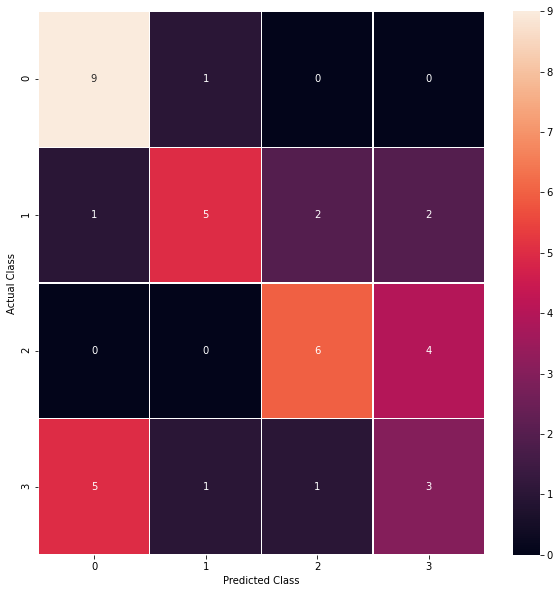

[1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0] [2.0, 1.0, 2.0, 1.0, 3.0, 4.0, 3.0, 1.0, 1.0, 1.0, 3.0, 2.0, 3.0, 3.0, 4.0, 4.0, 1.0, 1.0, 4.0, 4.0, 3.0, 4.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 4.0, 4.0, 1.0, 1.0, 1.0, 2.0, 3.0, 4.0, 3.0, 1.0, 2.0]
              precision    recall  f1-score   support

         1.0       0.60      0.90      0.72        10
         2.0       0.71      0.50      0.59        10
         3.0       0.67      0.60      0.63        10
         4.0       0.33      0.30      0.32        10

    accuracy                           0.57        40
   macro avg       0.58      0.57      0.56        40
weighted avg       0.58      0.57      0.56        40



In [22]:
y_pred = svclassifier.predict(X_test)
#result = [y_pred[i] == y_test[i] for i in range(len(y_test))]
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, linewidths=.1, fmt= '.0f',ax=ax).set_ylim(4,0)
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()
print(list(y_test),list(y_pred))
print(classification_report(y_test,y_pred))

In [21]:
param_grid = {'C': [0.01,0.1, 1, 10, 100,1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.00001, 10,100]}
clf_grid = GridSearchCV(SVC(kernel = 'linear'), param_grid)
clf_grid.fit(X_train, y_train)
print("Best Parameters:\n", clf_grid.best_params_)

Best Parameters:
 {'C': 1, 'gamma': 1}


In [16]:
scaler = preprocessing.MinMaxScaler()   # since the data set is not gaussian
scaled_df = scaler.fit_transform(X)
X = pd.DataFrame(scaled_df,columns = ocolumns)
X

,eeg1__spkt_welch_density__coeff_9,eeg1__spkt_welch_density__coeff_10,eeg1__spkt_welch_density__coeff_12,eeg1__spkt_welch_density__coeff_15,eeg2__spkt_welch_density__coeff_9,eeg2__spkt_welch_density__coeff_10,eeg2__spkt_welch_density__coeff_12,eeg2__spkt_welch_density__coeff_15,eeg3__spkt_welch_density__coeff_9,eeg3__spkt_welch_density__coeff_10,...,eeg6__spkt_welch_density__coeff_12,eeg6__spkt_welch_density__coeff_15,eeg7__spkt_welch_density__coeff_9,eeg7__spkt_welch_density__coeff_10,eeg7__spkt_welch_density__coeff_12,eeg7__spkt_welch_density__coeff_15,eeg8__spkt_welch_density__coeff_9,eeg8__spkt_welch_density__coeff_10,eeg8__spkt_welch_density__coeff_12,eeg8__spkt_welch_density__coeff_15
0,0.078458,0.000000,0.082858,0.592621,0.069686,0.033476,0.039440,0.485303,0.094847,0.178379,...,0.098729,0.515149,0.083310,0.071161,0.035698,0.403899,0.101287,0.007039,0.161776,0.219111
1,0.088861,0.021423,0.270706,0.704286,0.095792,0.043107,0.291638,0.596395,0.209185,0.119805,...,0.278375,0.666676,0.107496,0.075556,0.221805,0.500552,0.254235,0.263903,0.291994,0.114454
2,0.010456,0.006504,0.100459,0.079679,0.000000,0.000000,0.120063,0.098154,0.019407,0.000000,...,0.245135,0.045988,0.008363,0.010662,0.319200,0.077235,0.096402,0.110464,0.572603,0.107732
3,0.213417,0.015829,0.124429,0.163194,0.199963,0.054515,0.086010,0.161018,0.160590,0.127305,...,0.202748,0.122907,0.142535,0.177783,0.167773,0.164672,0.109984,0.177031,0.178389,0.167508
4,0.214356,0.648196,0.293946,0.295538,0.187450,0.594510,0.153591,0.276623,0.099387,0.460262,...,0.174134,0.231659,0.123869,0.999996,0.138244,0.336942,0.106253,0.309539,0.124740,0.130384
5,0.360892,0.379415,0.138639,0.143444,0.330802,0.424292,0.084140,0.040988,0.143820,0.282733,...,0.134846,0.040322,0.271025,0.548797,0.084872,0.000000,0.153573,0.207226,0.139628,0.000000
6,0.380075,0.452500,0.318782,0.362888,0.331973,0.500583,0.513028,0.312929,0.237743,0.516368,...,0.293859,0.329774,0.316399,0.488149,0.220230,0.314503,0.446956,0.445874,0.248700,0.366335
7,0.192718,0.091429,0.238794,0.522601,0.067114,0.076665,0.123549,0.264026,0.040231,0.080207,...,0.220927,0.262092,0.000000,0.090049,0.128710,0.097488,0.000000,0.000000,0.275715,0.084561
8,0.640411,0.347201,0.092984,0.326820,0.559724,0.329833,0.078227,0.563050,0.201300,0.251329,...,0.166383,0.336100,0.125000,0.322493,0.073915,0.466597,0.062141,0.115012,0.090342,0.385735
9,0.776568,0.103716,0.179976,0.465206,0.705505,0.073632,0.195305,0.278432,0.189913,0.021338,...,0.213187,0.464444,0.247514,0.000000,0.067609,0.387077,0.187518,0.019088,0.123842,0.350318


In [17]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.20, stratify = y)

svclassifier = SVC(kernel = 'linear',C = 1, gamma = 1)
# C = 1.0, gamma = 1.0 for linear kernel - selected using GridSearchCV - for dataset 40
# C = 1, gamma = 1 for rbf kernel - selected using GridSearchCV - for dataset 40
# C = 0.01, gamma = 10 for rbf kernel - selected using GridSearchCV - for dataset 80
# C = 10, gamma = 1 for linear kernel - selected using GridSearchCV - for dataset 80

svclassifier.fit(X_train,y_train)

SVC(C=1, gamma=1, kernel='linear')

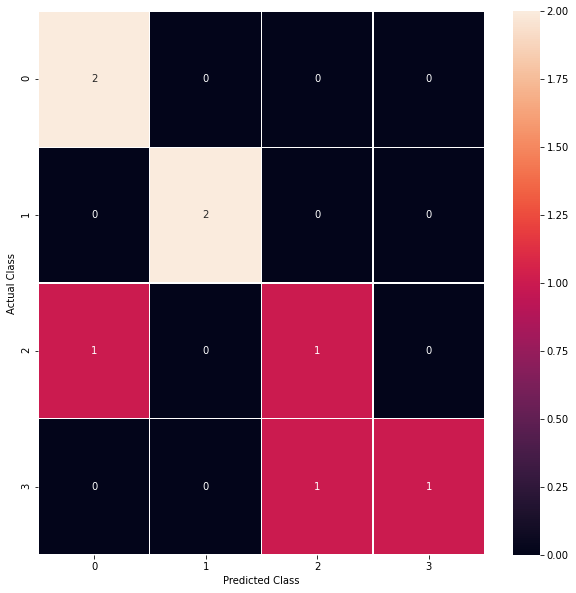

[4.0, 4.0, 3.0, 1.0, 3.0, 2.0, 1.0, 2.0] [4.0, 3.0, 3.0, 1.0, 1.0, 2.0, 1.0, 2.0]
              precision    recall  f1-score   support

         1.0       0.67      1.00      0.80         2
         2.0       1.00      1.00      1.00         2
         3.0       0.50      0.50      0.50         2
         4.0       1.00      0.50      0.67         2

    accuracy                           0.75         8
   macro avg       0.79      0.75      0.74         8
weighted avg       0.79      0.75      0.74         8



In [18]:
y_pred = svclassifier.predict(X_test)
#result = [y_pred[i] == y_test[i] for i in range(len(y_test))]
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, linewidths=.1, fmt= '.0f',ax=ax).set_ylim(4,0)
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()
print(list(y_test),list(y_pred))
print(classification_report(y_test,y_pred))

In [20]:
param_grid = {'C': [0.01,0.1, 1, 10, 100,1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.00001, 10,100]}
clf_grid = GridSearchCV(SVC(kernel = 'linear'), param_grid)
clf_grid.fit(X, y)
print("Best Parameters:\n", clf_grid.best_params_)

Best Parameters:
 {'C': 1, 'gamma': 1}


In [23]:
################  ALL_MODELS ######################

import sklearn
from sklearn.ensemble import *
from sklearn.neighbors import *
from sklearn.linear_model import *
from sklearn.svm import *
from sklearn.tree import *


# common models
model1=KNeighborsClassifier()
model2=RadiusNeighborsClassifier(radius=10)
model3=PassiveAggressiveClassifier()
model4=RidgeClassifier()
model5=RidgeClassifierCV()
model6=SGDClassifier()
model7=LinearSVC()
model8=NuSVC()
model9=SVC()
model10=DecisionTreeClassifier()
model11=ExtraTreeClassifier()

#models_from_ensemble
model12=AdaBoostClassifier()
model13=BaggingClassifier()
model14=ExtraTreesClassifier(n_estimators=1000)
model15=GradientBoostingClassifier()
model16=RandomForestClassifier()

# Using multiple models

estimators=[('model2',model2),('model12',model12),('model14',model14) ]

model17=StackingClassifier(estimators = estimators)
model18=VotingClassifier(estimators=estimators)

####################### all_models ############################
models=[model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,
        model12,model13,model14,model15,model16,model17,model18]

In [20]:
# TRAINING ALL THE MODELS

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

i=0
importances=[]
for model in models:
    i+=1
    try:
        model.fit(X_train,y_train)
    except Exception as e: print('Error in model.fit >>>',e)
    try:
        pred=model.predict(X_test)
    except Exception as e: print('Error in model.predict >>>',e)
    print(str(i)+'___'+str(model.__class__)+(100-len(str(model.__class__)))*'>'+'__',accuracy_score(y_test,pred))
    try:
        importances.append([i-1,model.feature_importances_])
    except AttributeError:
        pass

1___<class 'sklearn.neighbors._classification.KNeighborsClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.75
2___<class 'sklearn.neighbors._classification.RadiusNeighborsClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.25
3___<class 'sklearn.linear_model._passive_aggressive.PassiveAggressiveClassifier'>>>>>>>>>>>>>>>>>>>>>>>__ 0.75
4___<class 'sklearn.linear_model._ridge.RidgeClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.75
5___<class 'sklearn.linear_model._ridge.RidgeClassifierCV'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.75
6___<class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.625
7___<class 'sklearn.svm._classes.LinearSVC'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.75
8___<class 'sklearn.svm._classes.NuSVC'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.75
9___<class 'sklearn.svm._classes.SVC'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

In [25]:
X_train = run_tsfresh(filtered_eegs1,labels1)
y_train = labels1
X_test = run_tsfresh(filtered_eegs2,labels2)
y_test = labels2
ocolumns = X_train.columns

scaler = preprocessing.MinMaxScaler()   # since the data set is not gaussian
scaled_df = scaler.fit_transform(X_train)
X_train = pd.DataFrame(scaled_df,columns = ocolumns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = ocolumns)




(768, 8) (768,)
            eeg1       eeg2      eeg3      eeg4      eeg5       eeg6  \
0       1.361759   2.042735  1.404675  1.730365  2.311231   1.800908   
1      -0.212807   1.723444  1.248354  3.443060  4.246144   0.684169   
2      -1.238989   1.789432  1.410977  4.938497  5.731027  -0.108780   
3      -1.346529   2.475957  2.108778  6.104373  6.539843  -0.349718   
4      -0.373322   3.841685  3.445984  7.002299  6.770353   0.078768   
...          ...        ...       ...       ...       ...        ...   
30715 -19.617453 -13.933415 -9.934584 -7.720396 -2.546294 -10.623442   
30716 -17.896160 -13.004174 -8.544798 -6.479310 -1.897410  -9.821982   
30717 -13.764727 -10.044644 -6.262076 -4.628277 -1.268154  -7.605049   
30718  -8.034502  -5.732050 -3.653308 -2.641779 -0.819232  -4.448657   
30719  -1.549160  -0.774578 -1.029457 -0.737173 -0.551746  -0.847848   

           eeg7      eeg8   id  
0      2.374356  2.549810  NaN  
1      1.952908  3.227487  NaN  
2      1.582680  3.6

Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 30.99it/s]


   eeg1__spkt_welch_density__coeff_9  eeg1__spkt_welch_density__coeff_10  \
0                         150.681599                          104.710913   
1                         161.914220                          137.274643   
2                          77.254973                          114.598034   
3                         296.405987                          128.772277   
4                         297.420073                         1090.009740   

   eeg1__spkt_welch_density__coeff_12  eeg1__spkt_welch_density__coeff_15  \
0                          112.123592                          280.101035   
1                          249.221449                          323.256544   
2                          124.969262                           81.862757   
3                          142.463239                          114.139006   
4                          266.182954                          165.286501   

   eeg2__spkt_welch_density__coeff_9  eeg2__spkt_welch_density__coeff_10  \
0   

Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 32.12it/s]


   eeg1__spkt_welch_density__coeff_9  eeg1__spkt_welch_density__coeff_10  \
0                         283.711527                          250.353409   
1                        1108.621962                          498.341391   
2                         268.724690                          291.333997   
3                         238.112599                          194.494367   
4                         336.028474                          367.218959   

   eeg1__spkt_welch_density__coeff_12  eeg1__spkt_welch_density__coeff_15  \
0                          151.943506                           91.025008   
1                           52.635705                          280.164476   
2                          273.537979                          100.766363   
3                          244.118513                          150.394442   
4                           56.143170                           85.534834   

   eeg2__spkt_welch_density__coeff_9  eeg2__spkt_welch_density__coeff_10  \
0   

In [26]:
# TRAINING ALL THE MODELS

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

i=0
importances=[]
for model in models:
    i+=1
    try:
        model.fit(X_train,y_train)
    except Exception as e: print('Error in model.fit >>>',e)
    try:
        pred=model.predict(X_test)
    except Exception as e: print('Error in model.predict >>>',e)
    print(str(i)+'___'+str(model.__class__)+(100-len(str(model.__class__)))*'>'+'__',accuracy_score(y_test,pred))
    try:
        importances.append([i-1,model.feature_importances_])
    except AttributeError:
        pass

1___<class 'sklearn.neighbors._classification.KNeighborsClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.55
2___<class 'sklearn.neighbors._classification.RadiusNeighborsClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.25
3___<class 'sklearn.linear_model._passive_aggressive.PassiveAggressiveClassifier'>>>>>>>>>>>>>>>>>>>>>>>__ 0.575
4___<class 'sklearn.linear_model._ridge.RidgeClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.6
5___<class 'sklearn.linear_model._ridge.RidgeClassifierCV'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.65
6___<class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.575
7___<class 'sklearn.svm._classes.LinearSVC'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.6
8___<class 'sklearn.svm._classes.NuSVC'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>__ 0.55
9___<class 'sklearn.svm._classes.SVC'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

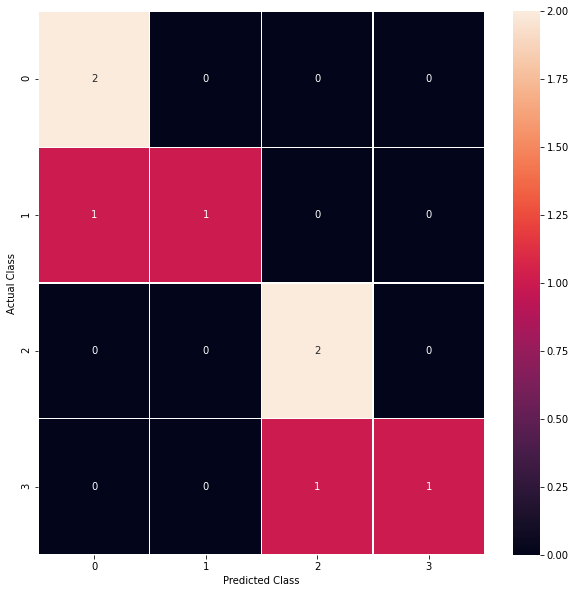

[3.0, 2.0, 1.0, 3.0, 4.0, 2.0, 4.0, 1.0] [3.0, 2.0, 1.0, 3.0, 3.0, 1.0, 4.0, 1.0]
              precision    recall  f1-score   support

         1.0       0.67      1.00      0.80         2
         2.0       1.00      0.50      0.67         2
         3.0       0.67      1.00      0.80         2
         4.0       1.00      0.50      0.67         2

    accuracy                           0.75         8
   macro avg       0.83      0.75      0.73         8
weighted avg       0.83      0.75      0.73         8



In [21]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.20, stratify = y)

svclassifier = SVC(gamma = 'auto')
# C = 1.0, gamma = 1.0 for linear kernel - selected using GridSearchCV
# C = 0.01, gamma = 100 for rbf kernel - selected using GridSearchCV

svclassifier.fit(X_train,y_train)

y_pred = svclassifier.predict(X_test)
#result = [y_pred[i] == y_test[i] for i in range(len(y_test))]
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, linewidths=.1, fmt= '.0f',ax=ax).set_ylim(4,0)
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()
print(list(y_test),list(y_pred))
print(classification_report(y_test,y_pred))

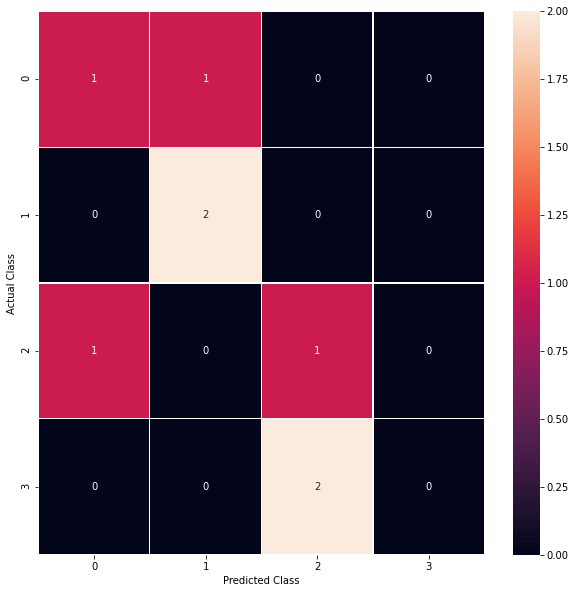

[1.0, 2.0, 4.0, 3.0, 3.0, 4.0, 2.0, 1.0] [2.0, 2.0, 3.0, 1.0, 3.0, 3.0, 2.0, 1.0]
              precision    recall  f1-score   support

         1.0       0.50      0.50      0.50         2
         2.0       0.67      1.00      0.80         2
         3.0       0.33      0.50      0.40         2
         4.0       0.00      0.00      0.00         2

    accuracy                           0.50         8
   macro avg       0.37      0.50      0.43         8
weighted avg       0.37      0.50      0.43         8



In [20]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.20, stratify = y)

svclassifier = SVC(kernel = 'rbf',C = 1, gamma = 1)
# C = 1.0, gamma = 1.0 for linear kernel - selected using GridSearchCV
# C = 0.01, gamma = 100 for rbf kernel - selected using GridSearchCV

svclassifier.fit(X_train,y_train)

y_pred = svclassifier.predict(X_test)
#result = [y_pred[i] == y_test[i] for i in range(len(y_test))]
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, linewidths=.1, fmt= '.0f',ax=ax).set_ylim(4,0)
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()
print(list(y_test),list(y_pred))
print(classification_report(y_test,y_pred))